Configuration set for Ticker: AAPL
--- Data Split Complete: Train size 43, Test size 11 ---

--- Processing Sentiment Data ---


Processing Sentiment: 100%|███████████████████████| 1/1 [00:00<00:00,  4.37it/s]


✅ Sentiment features created and saved.

Train Input Shape (X_train): (38, 3, 3)
Test Input Shape (X_test): (6, 3, 3)



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 3, 32)          │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,961 (50.63 KB)

 Trainable params: 12,961 (50.63 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Model ---


*** Final Results on Test Data ***
Test Set RMSE (Root Mean Squared Error): $1.8824
Actual (first 5): [346.13992558 347.00546972 347.87310261 348.15384079 347.71535836]
Predicted (first 5): [344.14203 344.59122 345.25858 346.69058 347.11682]


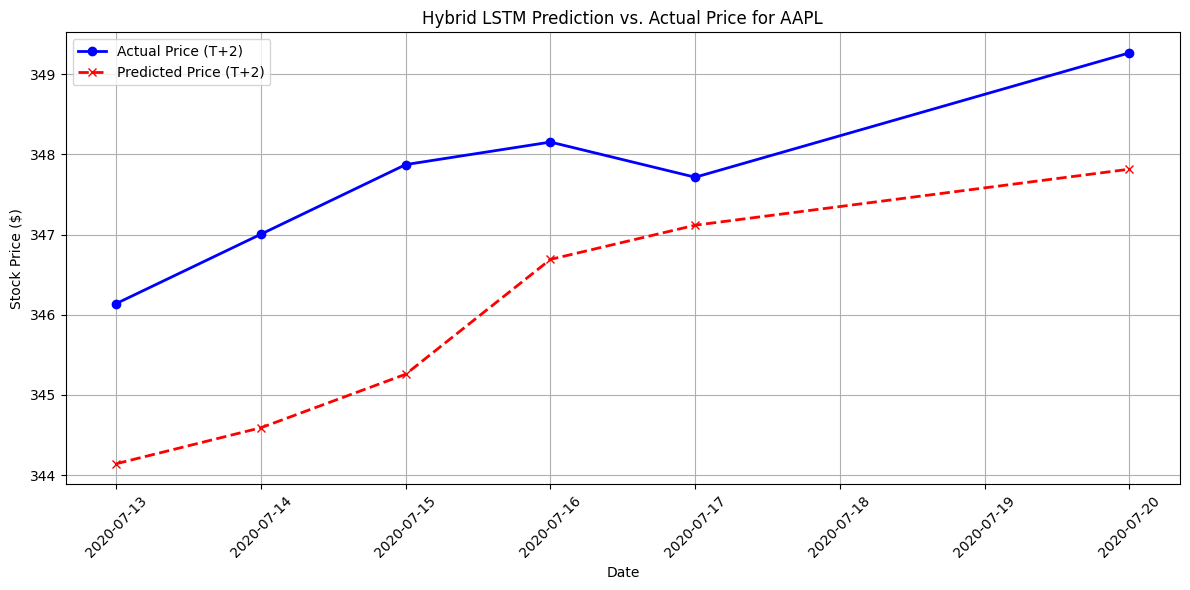


✅ Project execution complete.


In [2]:
# =========================================================================
# COMPLETE HYBRID FINBERT-LSTM STOCK PREDICTION WORKFLOW (FINAL WORKING VERSION)
# =========================================================================

# --------------------------------------------------------
# 0. ⚙️ SETUP: Imports and Configuration
# --------------------------------------------------------

import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- Configuration Variables ---
TICKER = 'AAPL' 
TRAIN_RATIO = 0.80 
TIME_STEPS = 3   
EPOCHS = 150     
BATCH_SIZE = 4  
FINBERT_MODEL = "ProsusAI/finbert" 
OUTPUT_DIR = TICKER
N_FEATURES = 3 # We are using 'close', 'sentiment_score', and 'volatility_3d'

os.makedirs(OUTPUT_DIR, exist_ok=True) 
print(f"Configuration set for Ticker: {TICKER}")


# --------------------------------------------------------
# 1. 📚 DATA PREPARATION: Mock Data, Merge, Target Creation, and Split
# --------------------------------------------------------

def create_mock_raw_data(ticker):
    """Creates mock raw data with reduced noise, adds volatility, and ensures array lengths match."""
    periods = 59 
    dates = pd.date_range(start='2020-05-01', periods=periods, freq='B')
    
    # Smoother base price with reduced noise
    base_price = np.linspace(310, 350, periods) 
    noise = np.random.randn(periods) * 1.5 
    close_prices = base_price + noise
    
    prices_df = pd.DataFrame({
        'date': dates,
        'close': close_prices
    })
    
    # Apply a small EMA for better pattern recognition
    prices_df['close'] = prices_df['close'].ewm(span=3, adjust=False).mean()

    # ENHANCEMENT 1: Add a Volatility Feature
    prices_df['log_return'] = np.log(prices_df['close'] / prices_df['close'].shift(1))
    prices_df['volatility_3d'] = prices_df['log_return'].rolling(window=3).std()
    
    # Drop NaNs from the rolling window calculation
    prices_df = prices_df.dropna(subset=['volatility_3d'])
    
    # Target creation (shift -2)
    prices_df['close_t_plus_2'] = prices_df['close'].shift(-2)
    
    # FIX: Drop NaNs from the target shift, then reset index
    prices_df = prices_df.dropna(subset=['close_t_plus_2']).reset_index(drop=True)

    # Use the dates from the FINAL prices_df for the news headlines!
    final_dates = prices_df['date'] 
    
    headlines = [
        "AAPL beats earnings estimates significantly.",
        "Analyst raises AAPL price target on strong iPhone sales.",
        "Market sentiment is bearish; technology stocks fall.",
        "New low-cost service launch expected to drive growth.",
        "Supply chain issues create near-term uncertainty."
    ] * (periods // 5 + 1)
    
    # Create daily_news using the dates and length of the final prices_df
    daily_news = pd.DataFrame({
        'date': final_dates.reset_index(drop=True), 
        'headline': headlines[:len(final_dates)] 
    }) 
    
    return prices_df, daily_news.reset_index(drop=True)

# --- LOAD AND PREPROCESS ---
prices_df, news_df = create_mock_raw_data(TICKER)

news_df['date'] = pd.to_datetime(news_df['date']).dt.tz_localize(None).dt.normalize()
prices_df['date'] = pd.to_datetime(prices_df['date']).dt.tz_localize(None).dt.normalize()

daily_news = news_df.groupby("date")['headline'].apply(lambda x: " [SEP] ".join(x)).reset_index()

prices_df = prices_df.sort_values('date')

# Merge price/volatility features with news headlines and target
dataset = pd.merge(daily_news, prices_df[['date', 'close', 'close_t_plus_2', 'volatility_3d']], on='date', how='inner').dropna(subset=['close_t_plus_2']).sort_values('date').reset_index(drop=True)

split_index = int(len(dataset) * TRAIN_RATIO)
train_df = dataset.iloc[:split_index].copy()
test_df = dataset.iloc[split_index:].copy()

train_df.to_csv(os.path.join(OUTPUT_DIR, "train.csv"), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, "test.csv"), index=False)

print(f"--- Data Split Complete: Train size {len(train_df)}, Test size {len(test_df)} ---")


# --------------------------------------------------------
# 2. 🧠 FEATURE ENGINEERING: FinBERT Sentiment Extraction
# --------------------------------------------------------

def get_finbert_sentiment(headlines_list, model, tokenizer, device, batch_size=32):
    """Calculates sentiment scores in batches using FinBERT."""
    sentiment_scores = []
    for i in tqdm(range(0, len(headlines_list), batch_size), desc="Processing Sentiment"):
        batch = headlines_list[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
        composite_score = probabilities[:, 0] - probabilities[:, 1]
        sentiment_scores.extend(composite_score)
    return np.array(sentiment_scores)

# Initialize Model (using safetensors fix)
tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL)
model_sentiment = AutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL, use_safetensors=True) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sentiment.to(device)

train_df_raw = pd.read_csv(os.path.join(OUTPUT_DIR, "train.csv"))
test_df_raw = pd.read_csv(os.path.join(OUTPUT_DIR, "test.csv"))

print("\n--- Processing Sentiment Data ---")
train_df_raw['sentiment_score'] = get_finbert_sentiment(train_df_raw['headline'].astype(str).tolist(), model_sentiment, tokenizer, device)
test_df_raw['sentiment_score'] = get_finbert_sentiment(test_df_raw['headline'].astype(str).tolist(), model_sentiment, tokenizer, device)

train_df_raw.to_csv(os.path.join(OUTPUT_DIR, "train_features.csv"), index=False)
test_df_raw.to_csv(os.path.join(OUTPUT_DIR, "test_features.csv"), index=False)

print(f"\n✅ Sentiment features created and saved.")


# --------------------------------------------------------
# 3. 🏗️ HYBRID LSTM: Scaling, Sequence Creation, and Training
# --------------------------------------------------------

# Load Feature-Engineered Data
train_df = pd.read_csv(os.path.join(OUTPUT_DIR, "train_features.csv"), parse_dates=['date'])
test_df = pd.read_csv(os.path.join(OUTPUT_DIR, "test_features.csv"), parse_dates=['date'])

# Updated Feature List
FEATURES = ['close', 'sentiment_score', 'volatility_3d'] 
TARGET = 'close_t_plus_2'

# --- Robust Scaling ---
X_train_raw = train_df[FEATURES].values
y_train_raw = train_df[TARGET].values.reshape(-1, 1)

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

train_features_scaled = feature_scaler.fit_transform(X_train_raw)
target_scaled = target_scaler.fit_transform(y_train_raw)

train_scaled = np.hstack((train_features_scaled, target_scaled))
test_features_scaled = feature_scaler.transform(test_df[FEATURES].values)
# test_scaled includes the RAW target price in the last column
test_scaled = np.hstack((test_features_scaled, test_df[TARGET].values.reshape(-1, 1))) 


# --- Sequence Creation Function ---
def create_sequences(data, time_steps, target_index, N_FEATURES):
    X, y = [], []
    for i in range(len(data) - time_steps - 2): 
        X.append(data[i:(i + time_steps), :N_FEATURES])
        y.append(data[i + time_steps + 2, target_index]) 
    return np.array(X), np.array(y)

# Generate sequences
# target_index for train_scaled is N_FEATURES (the scaled target)
X_train, y_train = create_sequences(train_scaled, TIME_STEPS, N_FEATURES, N_FEATURES)
# target_index for test_scaled is N_FEATURES (the RAW target)
X_test, y_test = create_sequences(test_scaled, TIME_STEPS, N_FEATURES, N_FEATURES)

print(f"\nTrain Input Shape (X_train): {X_train.shape}")
print(f"Test Input Shape (X_test): {X_test.shape}")


# --- Build and Train the Model (Refined Architecture) ---
model = Sequential()
# Input shape uses the new N_FEATURES=3
model.add(LSTM(units=32, return_sequences=True, input_shape=(TIME_STEPS, N_FEATURES))) # Reduced units
model.add(Dropout(0.4)) # INCREASED DROPOUT

model.add(LSTM(units=32)) # Reduced units
model.add(Dropout(0.4)) # INCREASED DROPOUT

model.add(Dense(units=1))

# Lowered Learning Rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error') 
model.summary()

# Define Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10,         
    restore_best_weights=True
)
    
print("\n--- Training Model ---")
history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1,  
    verbose=0,
    callbacks=[early_stopping] 
)


# --------------------------------------------------------
# 4. ✅ EVALUATION AND 📈 VISUALIZATION
# --------------------------------------------------------

# --- Evaluate the Model (Fixed for small datasets) ---
y_pred_scaled = model.predict_on_batch(X_test) 

# Actual (y_test) is already in raw dollar values
y_test_original = y_test.reshape(-1, 1) 

# Predicted (y_pred_scaled) must be inverse transformed
y_pred_original = target_scaler.inverse_transform(y_pred_scaled)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

print(f"\n\n*** Final Results on Test Data ***")
print(f"Test Set RMSE (Root Mean Squared Error): ${rmse:.4f}")
print(f"Actual (first 5): {y_test_original[:5].flatten()}")
print(f"Predicted (first 5): {y_pred_original[:5].flatten()}")

# --- Visualization ---

start_index_in_test_df = TIME_STEPS + 2

# We must adjust the index start because the mock data dropped more rows now
result_df = pd.DataFrame({
    'date': test_df['date'].iloc[start_index_in_test_df:start_index_in_test_df + len(y_test_original)].reset_index(drop=True),
    'Actual Price': y_test_original.flatten(),
    'Predicted Price': y_pred_original.flatten()
})

plt.figure(figsize=(12, 6))

# Plot Actual Prices
plt.plot(result_df['date'], result_df['Actual Price'], 
         label='Actual Price (T+2)', 
         marker='o', linestyle='-', linewidth=2, color='blue')

# Plot Predicted Prices
plt.plot(result_df['date'], result_df['Predicted Price'], 
         label='Predicted Price (T+2)', 
         marker='x', linestyle='--', linewidth=2, color='red')

plt.title(f'Hybrid LSTM Prediction vs. Actual Price for {TICKER}')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✅ Project execution complete.")